# Figure 3: Accuracy vs test size

In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools as it

import gpflow

import guepard
from guepard.utilities import get_gpr_submodels

/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/nicolasdurrande/projects/guepard/.venv/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


In [2]:
def get_data(num_data, kernel):
    X = np.linspace(0, 1, num_data)[:, None]
    Y = gpflow.models.GPR((np.c_[-10.], np.c_[0.]), kernel, noise_variance=NOISE_VAR).predict_f_samples(X)
    return X, Y


def get_subset_of_data(A: np.ndarray, step: int) -> np.ndarray:
    """
    Returns a subarray of `A`. The elements in the subarray depend on `step`.
    For `step` equal to 0, the subarray consists of a single element which will be
    the the middle element of `A`. For `step` >= 1, the subarray contains the (2**step + 1)
    middle elements.
    """
    middle_index = len(A)//2
    if step == 0:
        return A[[middle_index]]
    else:
        pad = int(2 ** (step - 1))  # 1, 2, 4, 8, ...
        return np.linspace(0, 1, 2**(step)+1)[:, None]
        return A[middle_index - pad: middle_index + pad + 1]


def get_aggregate_model(X, Y, num_splits, kernel):
    x_list = np.array_split(X, num_splits)  # list of num_split np.array
    y_list = np.array_split(Y, num_splits)  
    datasets = list(zip(x_list, y_list))

    submodels = get_gpr_submodels(datasets, kernel, mean_function=None, noise_variance=NOISE_VAR) # list of num_split GPR models
    m_agg = guepard.EquivalentObsEnsemble(submodels)
    return m_agg


def kl_univariate_gaussians(mu_1, sigma_1, mu_2, sigma_2):
    """
    KL(p || q), where p = N(mu_1, sigma_1^2), and q = N(mu_2, sigma_2^2)
    """
    logs =  np.log(sigma_2) - np.log(sigma_1)
    a = (sigma_1**2 + (mu_1 - mu_2) **2) / (2. * sigma_2**2)
    return logs + a - 0.5


def compare_full_vs_agg(X, full, agg):
    mus = []
    sigmas = []
    len_x_subset = []

    for i in range(LN_NUM_DATA + 1):
        xx = get_subset_of_data(X, i)
        m, v = agg.predict_f(xx)
        mus.append(m.numpy().flatten()[len(xx) // 2])
        sigmas.append(v.numpy().flatten()[len(xx) // 2] ** 0.5)
        len_x_subset.append(len(xx))

    m, v = full.predict_f(get_subset_of_data(X, 0))
    m_full = m.numpy().flatten()[0]
    sigma_full = v.numpy().flatten()[0] ** 0.5

    kls = [
        kl_univariate_gaussians(m, s, m_full, sigma_full) for m, s in zip(mus, sigmas)
    ]

    return len_x_subset, kls

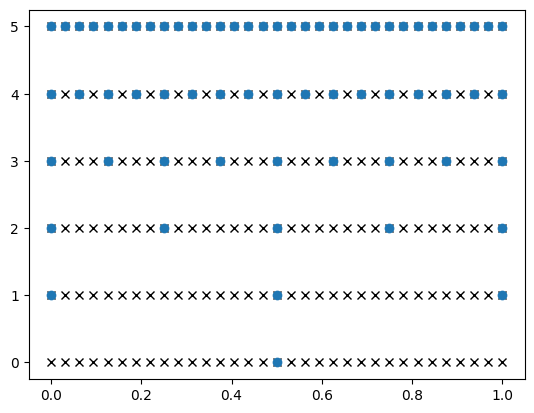

In [3]:
NOISE_VAR = 1e-1
LN_NUM_DATA = 5  # num_datapoints = 2 ** LN_NUM_DATA + 1
REPS_ITER = range(50)
NUM_SPLITS_ITER = [2, 4, 8, 12, 16]
KERNEL = gpflow.kernels.SquaredExponential(lengthscales=.25)

X, Y = get_data(2 ** LN_NUM_DATA + 1, KERNEL)

for i in range(LN_NUM_DATA + 1):
    plt.plot(X, 0*X + i, 'kx')
    xx = get_subset_of_data(X, i)
    plt.plot(xx, 0*xx + i, 'C0o')

In [4]:
results = []

for rep, num_splits in it.product(REPS_ITER, NUM_SPLITS_ITER):
    print(rep, num_splits)
    X, Y = get_data(2 ** LN_NUM_DATA + 1, KERNEL)
    full_gpr = gpflow.models.GPR((X, Y), KERNEL, noise_variance=NOISE_VAR)
    agg_gpr = get_aggregate_model(X, Y, num_splits, KERNEL)
    size, kl = compare_full_vs_agg(X, full_gpr, agg_gpr)
    results.extend({"rep": rep, "num_splits": num_splits, "kl": k, "size": s} for s,k in zip(size, kl))

0 2
0 4
0 8
0 12
0 16
1 2
1 4
1 8
1 12
1 16
2 2
2 4
2 8
2 12
2 16
3 2
3 4
3 8
3 12
3 16
4 2
4 4
4 8
4 12
4 16
5 2
5 4
5 8
5 12
5 16
6 2
6 4
6 8
6 12
6 16
7 2
7 4
7 8
7 12
7 16
8 2
8 4
8 8
8 12
8 16
9 2
9 4
9 8
9 12
9 16
10 2
10 4
10 8
10 12
10 16
11 2
11 4
11 8
11 12
11 16
12 2
12 4
12 8
12 12
12 16
13 2
13 4
13 8
13 12
13 16
14 2
14 4
14 8
14 12
14 16
15 2
15 4
15 8
15 12
15 16
16 2
16 4
16 8
16 12
16 16
17 2
17 4
17 8
17 12
17 16
18 2
18 4
18 8
18 12
18 16
19 2
19 4
19 8
19 12
19 16
20 2
20 4
20 8
20 12
20 16
21 2
21 4
21 8
21 12
21 16
22 2
22 4
22 8
22 12
22 16
23 2
23 4
23 8
23 12
23 16
24 2
24 4
24 8
24 12
24 16
25 2
25 4
25 8
25 12
25 16
26 2
26 4
26 8
26 12
26 16
27 2
27 4
27 8
27 12
27 16
28 2
28 4
28 8
28 12
28 16
29 2
29 4
29 8
29 12
29 16
30 2
30 4
30 8
30 12
30 16
31 2
31 4
31 8
31 12
31 16
32 2
32 4
32 8
32 12
32 16
33 2
33 4
33 8
33 12
33 16
34 2
34 4
34 8
34 12
34 16
35 2
35 4
35 8
35 12
35 16
36 2
36 4
36 8
36 12
36 16
37 2
37 4
37 8
37 12
37 16
38 2
38 4
38 8
38 12
38 

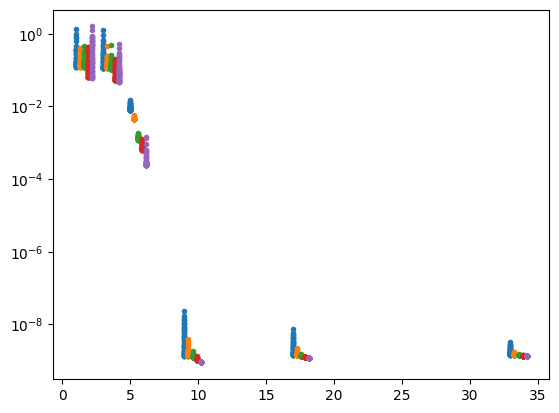

In [5]:
df = pd.DataFrame(results)
for i, num_splits in enumerate(NUM_SPLITS_ITER): 
    x_ = df[df.num_splits==num_splits]['size']+.3 * i
    y_ = df[df.num_splits==num_splits].kl
    plt.plot(x_, y_, f'C{i}.')

plt.yscale('log')

      rep  num_splits            kl  size
0       0           2  1.271256e-01     1
1       0           2  1.730103e-01     3
2       0           2  8.910813e-03     5
3       0           2  9.313539e-09     9
4       0           2  3.764438e-09    17
...   ...         ...           ...   ...
1495   49          16  5.265848e-01     3
1496   49          16  5.776344e-04     5
1497   49          16  9.285939e-10     9
1498   49          16  1.157950e-09    17
1499   49          16  1.326075e-09    33

[1500 rows x 4 columns]


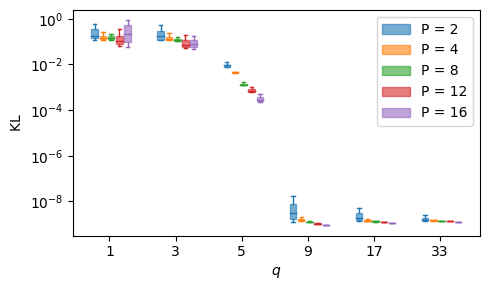

In [6]:
df = pd.DataFrame(results)
print(df)

fig, ax = plt.subplots(figsize=(5, 3))
def box_plot(data, x, label, edge_color, fill_color, manage_ticks=False):
    bp = ax.boxplot(data, positions=[x], patch_artist=True, manage_ticks=manage_ticks, showfliers=False, widths=.2)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        patch.set(alpha=.6)       
    
    return bp


bps = []
for i, num_splits in enumerate(NUM_SPLITS_ITER):
    for j in range(LN_NUM_DATA + 1):
        s = len(get_subset_of_data(X, j))
        data = df[(df.num_splits==num_splits) & (df['size'] == s)]['kl'].values
        x = 2 * j + (i * .25) - .45
        bp = box_plot(data, x, i, edge_color=f'C{i}', fill_color=f'C{i}')
        if j == 0:
            bps.append(bp)


labels = map(lambda s: f"P = {s}", NUM_SPLITS_ITER)
ax.legend([bp["boxes"][0] for bp in bps], labels, loc='upper right')

plt.xticks(2 * np.arange(6), df['size'].unique())
plt.yscale('log')
plt.xlabel("$q$")
plt.ylabel("$\mathrm{KL}$")
plt.tight_layout()
plt.savefig("figures/acc_vs_testsize.pdf")